## Remplissage du dataset des pit-stops

Le dataset que nous utilisons est incomplet : en effet, il ne propose les informations de pit-stop qu'à partir de la 841e course, alors que les données des temps au tour sont disponibles pour beaucoup plus de courses. Nous souhaitons remplir ce dataset.

On remarque qu'un pit-stop est symbolisé sur le graphique des temps au tour par un pic brusque entre deux tours rapides. Il est donc possible d'utiliser un algorithme d'apprentissage supervisé pour trouver les pit-stops à chaque course.

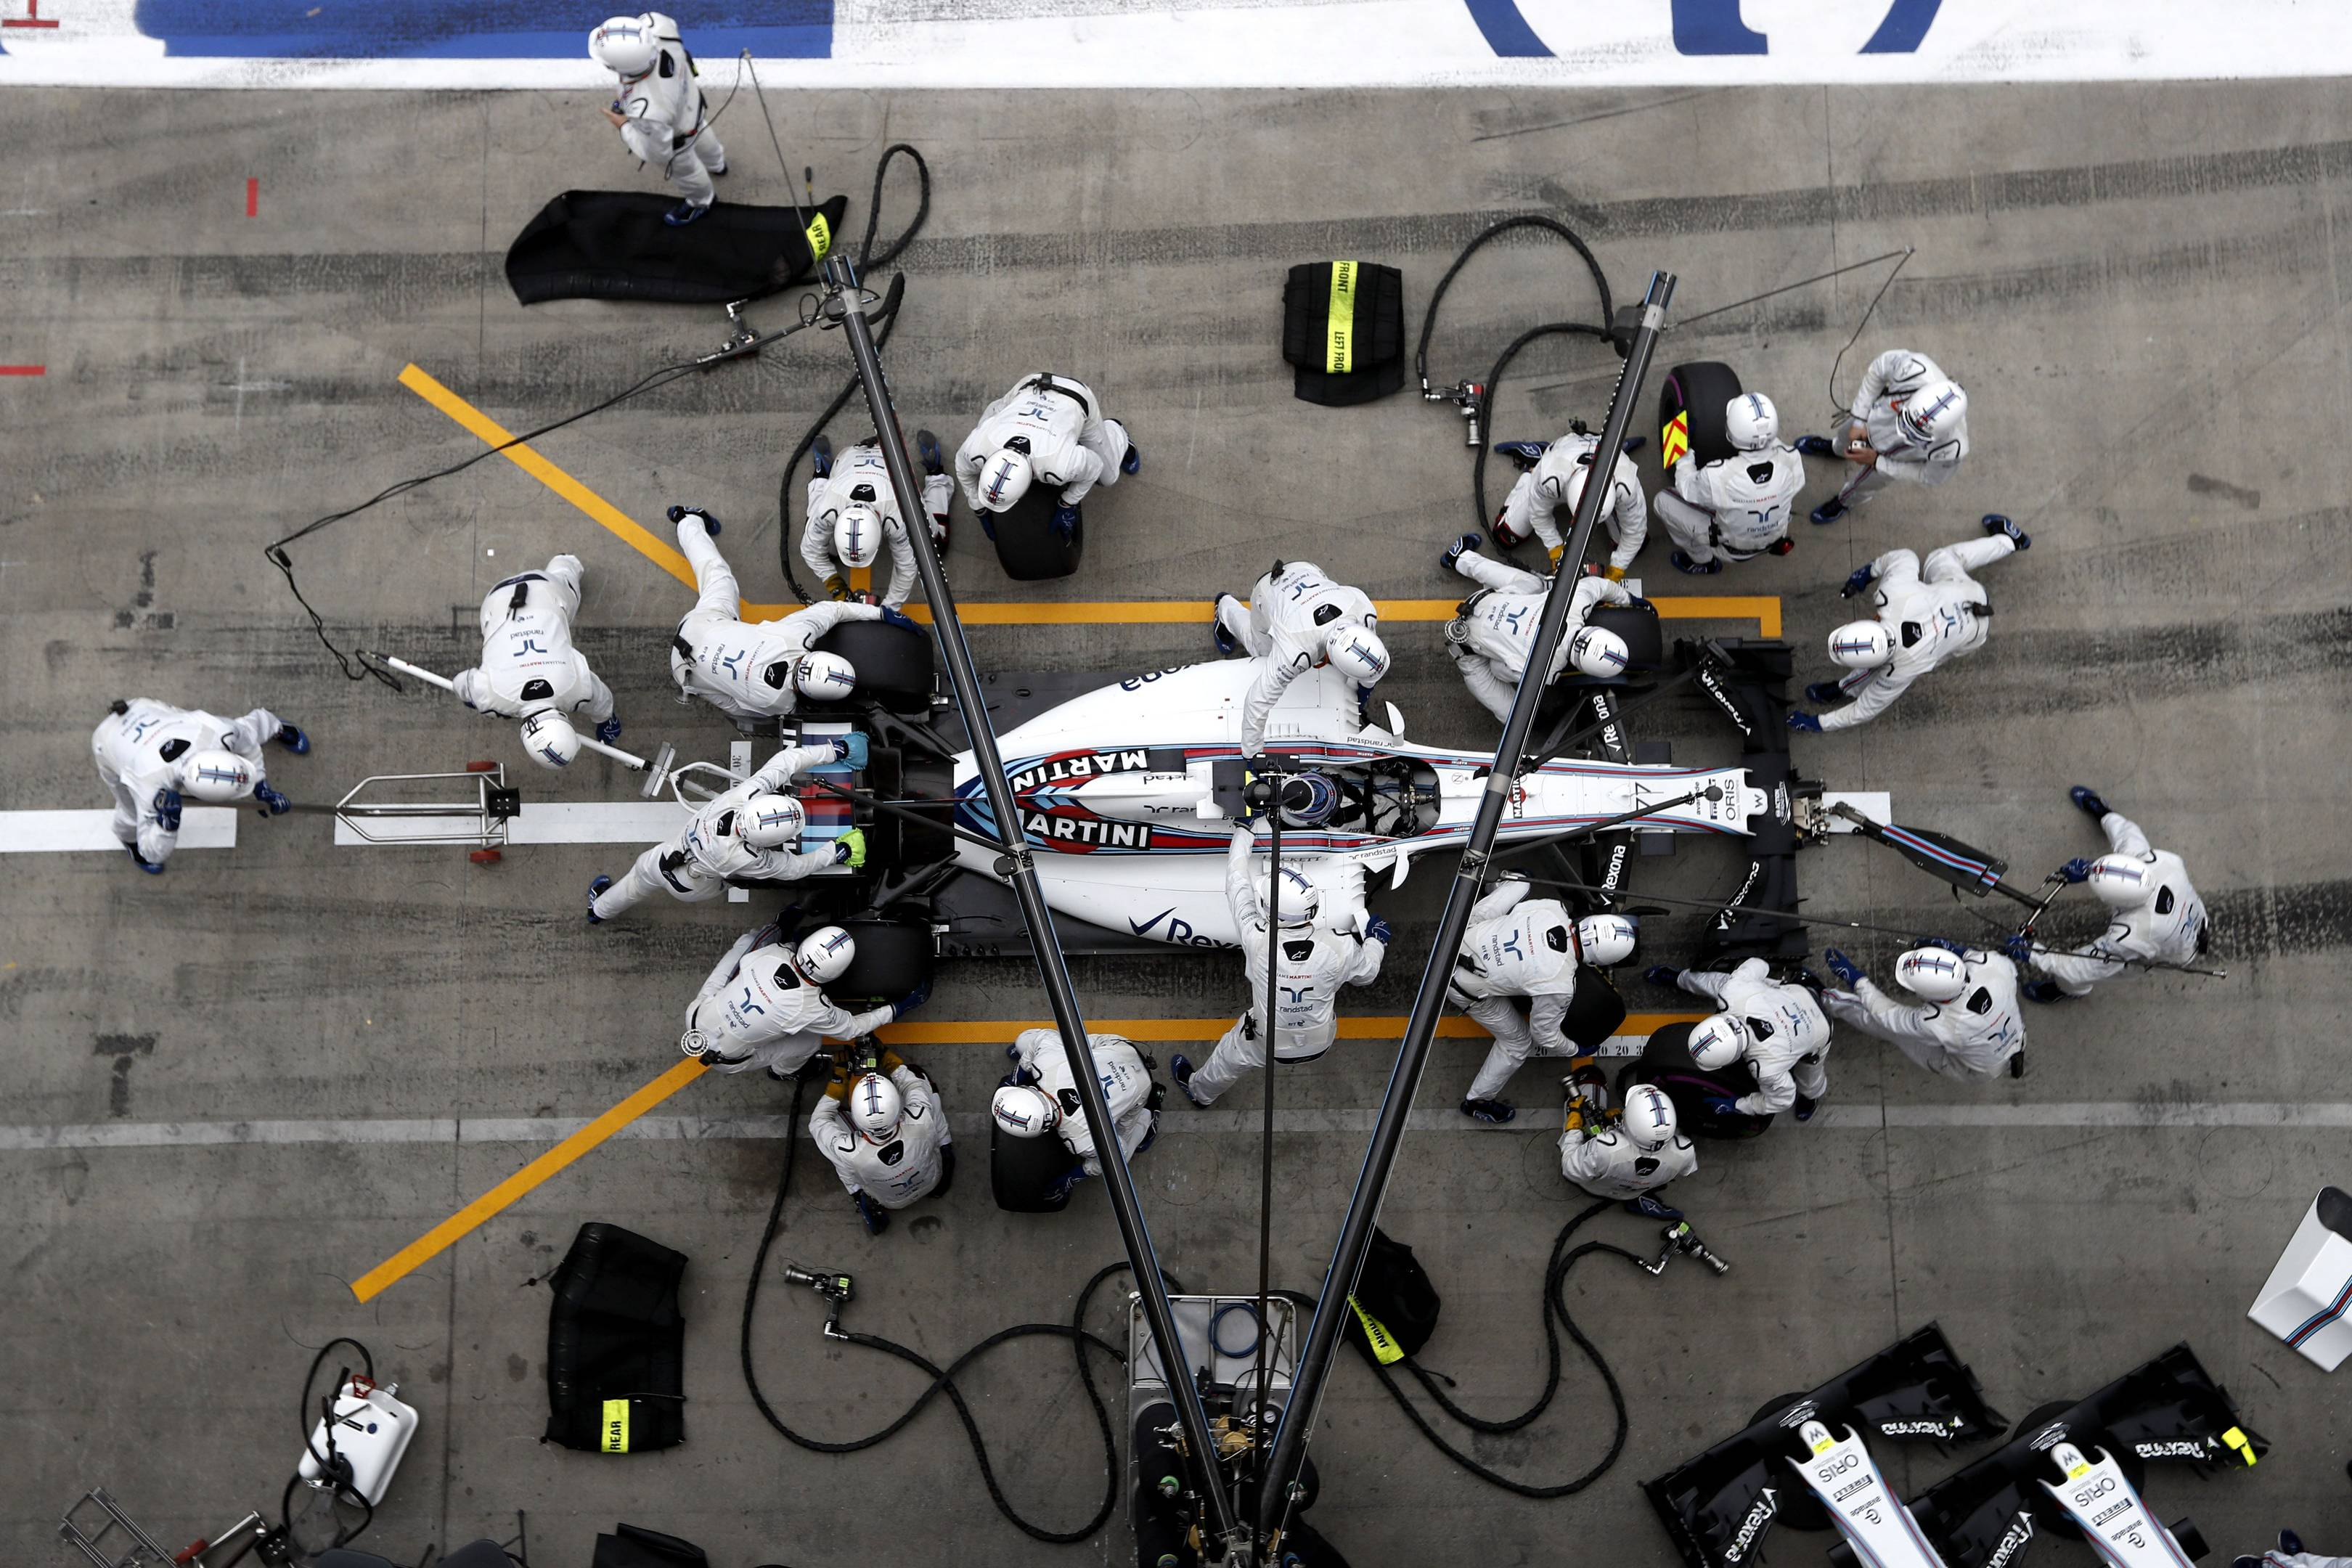

In [1]:
import os
import tempfile
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

sns.set()
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [2]:
pitStops = pd.read_csv("datasets/pit_stops.csv")
lapTimes = pd.read_csv("datasets/lap_times.csv")
races = pd.read_csv("datasets/races.csv",index_col=0)
races = races.drop(columns=['url','time'])

### Préparation du dataset

- On importe un fichier csv nommé dataset_pit.csv contenant la liste des résultats dees courses où les informations de pit-stop sont disponibles. Retrouver ces informations a pris beaucoup de temps, c'est pourquoi nous avons directement exporté le résultat afin de pouvoir le réutiliser.

- On crée la colonne lapDelta qui nous apporte des informations sur le temps des tours précédent et suivant par rapport au tour actuel.

- Enfin, on applique une fonction à lapDelta afin de clarifier les résultats pour un meilleur apprentissage.

In [3]:
#dataset_pit.csv a été généré par moi, il contient les courses dont on connaît les informations de pit
my_dataset = pd.read_csv('dataset_pit.csv', index_col=0)
#En raison d'incidents pouvant survenir en début de course, on a beaucoup de pits dans les premiers tours
#Ils créent un bruit inutile et peuvent rendre la prédiction moins précise
#On retire donc les informations de tour avant le 5e tour.
my_dataset = my_dataset[my_dataset['lap'] > 5]

#On va créer une colonne contenant le temps du tour précédent
my_dataset['previousLap'] = np.zeros(my_dataset.shape[0])

#Pour ce faire, on effectue une translation du dataset dans une copie.
my_dataset_trans = my_dataset.shift(1)

#On duplique la première ligne pour qu'elle ne soit pas vide
my_dataset_trans.iloc[0] = my_dataset.iloc[0]

#On associe les deux champs. On rajoute raceId et driverId pour que le tour précédent corresponde bien au bon pilote.
my_dataset['previousLap'] = my_dataset_trans['milliseconds']
my_dataset['previousLapRaceId'] = my_dataset_trans['raceId']
my_dataset['previousLapDriverId'] = my_dataset_trans['driverId']
my_dataset['previousLapPit'] = my_dataset_trans['pit']

#Le rapport du temps au tour actuel et du temps au tour précédent.
my_dataset['previousLapDelta'] = np.where((my_dataset['raceId'] == my_dataset['previousLapRaceId']) & (my_dataset['driverId'] == my_dataset['previousLapDriverId']) & my_dataset['previousLapPit'] != 1, my_dataset['milliseconds']/my_dataset['previousLap'], 1)

#On répète exactement la même opération pour le tour suivant
my_dataset_fwd = my_dataset.shift(-1)
my_dataset_fwd.loc[my_dataset_fwd.shape[0]] =  my_dataset.loc[my_dataset.shape[0]]
my_dataset['nextLap'] = my_dataset_fwd['milliseconds']
my_dataset['nextLapRaceId'] = my_dataset_fwd['raceId']
my_dataset['nextLapDriverId'] = my_dataset_fwd['driverId']
my_dataset['nextLapPit'] = my_dataset_fwd['pit']
my_dataset['nextLapDelta'] = np.where((my_dataset['raceId'] == my_dataset['nextLapRaceId']) & (my_dataset['driverId'] == my_dataset['nextLapDriverId']) & my_dataset['nextLapPit'] != 1, (my_dataset['milliseconds']/my_dataset['nextLap']), 1)

#lapDelta correspond à la différence du tour actuel par rapport au précédent ET au suivant
my_dataset['lapDelta'] = (my_dataset['previousLapDelta']+my_dataset['nextLapDelta'])/2

#On accentue les résultats : si lapDelta ~ 1 alors on affecte une valeur 1-exp(1-1) ~ 0 
#                            si lapDelta >> 1 alors on affecte une valeur 10*(1-exp(1-1,5)) >~ 1
my_dataset['lapDelta'] = my_dataset['lapDelta'].apply(lambda x: 10.0*(1-np.exp(1-x)))

#On centre les résultats (attention : l'algorithme fonctionne mieux si on ne le fait pas)
# my_dataset['lapDelta'] = (my_dataset['lapDelta']-my_dataset['lapDelta'].mean())/my_dataset['lapDelta'].std()

#Si la valeur est plus petite que 0,05 on affecte 0, sinon on multiplie par 10
#"Feature engineering at its finest"
my_dataset['lapDelta'] = np.where((np.abs(my_dataset['lapDelta']) < 0.05) | (my_dataset['pit'] == 0),0,10*my_dataset['lapDelta'])

#On retire les colonnes dont on n'a pas besoin
my_dataset = my_dataset.drop(['previousLap','previousLapRaceId','previousLapDriverId','nextLap','nextLapRaceId','nextLapDriverId'],axis=1)

#On retire les 50 valeurs les plus grandes qui peuvent empêcher un apprentissage de qualité
for i in range(1,50):
    my_dataset = my_dataset.drop(my_dataset['previousLapDelta'].idxmax())
    my_dataset = my_dataset.drop(my_dataset['nextLapDelta'].idxmax())

#On affiche le dataset préparé.    
display(my_dataset.head(10))

,raceId,driverId,lap,milliseconds,circuitId,pit,previousLapPit,previousLapDelta,nextLapPit,nextLapDelta,lapDelta
5,841,20,6,92605,1,0.0,0.0,1.000000,0.0,1.001113,0.000000
6,841,20,7,92502,1,0.0,0.0,0.998888,0.0,0.999622,0.000000
7,841,20,8,92537,1,0.0,0.0,1.000378,0.0,0.992460,0.000000
8,841,20,9,93240,1,0.0,0.0,1.007597,0.0,1.007216,0.000000
9,841,20,10,92572,1,0.0,0.0,0.992836,0.0,0.998953,0.000000
10,841,20,11,92669,1,0.0,0.0,1.001048,0.0,0.997492,0.000000
11,841,20,12,92902,1,0.0,0.0,1.002514,0.0,0.991505,0.000000
12,841,20,13,93698,1,0.0,0.0,1.008568,1.0,1.000000,0.000000
13,841,20,14,112075,1,1.0,0.0,1.196130,0.0,1.139147,15.434066
14,841,20,15,98385,1,0.0,1.0,1.000000,0.0,1.074682,0.000000


On peut transformer le problème en un problème de régression logistique : <b>A un tour donné, quelle est la probablilité qu'un pilote réalise un arrêt au stand ?

On peut remarquer ici que seuls 4% des labels représentent un arrêt au stand : les données ne sont pas du tout équitablement réparties !!

In [4]:
neg, pos = np.bincount(my_dataset['pit'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 143335
    Positive: 5756 (4% of total)



On crée les ensembles d'entraînement, de validation et de test. Pour la régression logistique codée à la main, nous préférerons équilibrer le dataset en retirant une majorité de labels négatifs afin que l'algorithme puisse donner plus d'importance aux labels positifs.

In [5]:
#On tente de prédire avec une seule feature mais qui est la combinaison de plusieurs autres
cleaned_df = my_dataset[['lapDelta','pit']]
#On retire les valeurs nulles
cleaned_df = cleaned_df.dropna()
cleaned_df_keras = cleaned_df.copy() #On crée une copie pour entrainer Keras 

# on constate que le dataset contient beacoup de negative(pas de pit-stop) et peu de positive, pour équilibrer le dataset on prend qu'une portion des négative
negative = cleaned_df[cleaned_df['pit']==0]
part1 = negative.sample(frac=0.1)
part2 = cleaned_df[cleaned_df['pit']==1]
cleaned_df = part1.append(part2)
cleaned_df.sample(frac=1) # pour mélanger l'ordre des ligne 

#On utilise une fonction de sklearn pour créer les ensembles d'entraînement et de test.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

#On extrait les labels et les données
train_labels = np.array(train_df.pop('pit'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('pit'))
test_labels = np.array(test_df.pop('pit'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

# #On sépare le dataset pour pouvoir affecter des poids de classe : ceci est important pour contrebalancer
# #le fait que les classes sont inéquitablement réparties
# """ATTENTION : PAS ENCORE IMPLEMENTE DANS L'ALGORITHME DE REGRESSION"""
# pit_y = cleaned_df[cleaned_df['pit'] == 1]
# pit_n = cleaned_df[cleaned_df['pit'] == 0]
# neg = pit_n["pit"].count()
# pos = pit_y['pit'].count()
# total = neg+pos
# display(pit_y.describe())
# display(pit_n.describe())
# #On divise par 2 pour garder la perte dans le même ordre de grandeur
# weight_for_0 = (1.0 / neg)*(total)/2.0 
# weight_for_1 = (1.0 / pos)*(total)/2.0

# class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [6]:
print(np.shape(train_features))

(12488, 1)


In [7]:
from logistic import LogisticClassifier
classifier = LogisticClassifier(0.3)
model = classifier.fit(train_features.T, train_labels,num_iterations = 2000, learning_rate = 0.05, print_cost = True)

train accuracy: 91.567905189 % 



In [8]:
#On récupère l'historique des coûts
costH = model['costs']
#On récupère les prédictions
predictions = classifier.predict(test_features.T)
test_labels = np.transpose(test_labels)
# print(predictions.tolist())
print(np.sum(predictions))
print(test_labels.shape)


863.0
(3903,)


Text(0.5,0.98,'Evolution du cout en fonction des iterations')

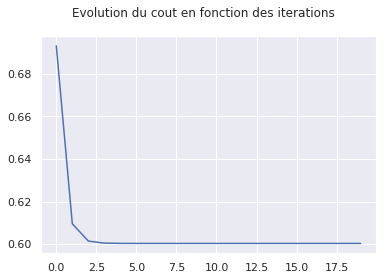

In [9]:
plt.plot(costH)
plt.suptitle('Evolution du cout en fonction des iterations')

In [10]:
def CM(real,predicted):
    matrix = np.zeros((2,2),dtype='int32')
    p = np.array(predicted).flatten()
    r = np.array(real).flatten()
    matrix[1,1] = len(r[(p==r) & (p==1)])        #true positive
    matrix[0,0] = len(r[(p==r) & (p==0)])       #true negative
    matrix[1,0] = len(r[(p!=r) & (r==1)])       # false negative
    matrix[0,1] = len(r[(p!=r) & (r==0)]) # false positive

    return matrix 

Text(0.5,21.5,'Label predit')

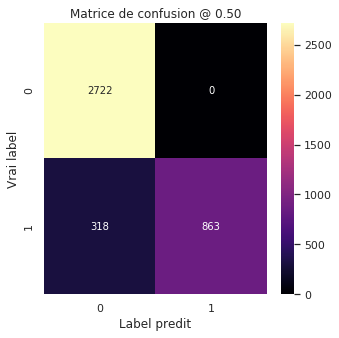

In [11]:
cm = CM(test_labels,predictions)
plt.figure(figsize=(5,5))
p = 0.5
sns.heatmap(cm, annot=True, fmt="d", cmap='magma')
plt.title('Matrice de confusion @ {:.2f}'.format(p))
plt.ylabel('Vrai label')
plt.xlabel('Label predit')

In [12]:
TP = cm[1][1] #Vrais positifs
TN = cm[0][0] #Vrais négatifs
FP = cm[0][1] #Faux positifs
FN = cm[1][0] #Faux négatifs
precision = 1.0*TP/(TP+FP)
recall = 1.0*TP/(TP+FN)
accuracy = (1.0*TP+TN)/(TP+TN+FP+FN)
f1 = 2.0*(1.0*precision*recall)/(1.0*precision + recall)
tfp = 1.0*FP/(1.0*FP+TN)
print("Précision : {}".format(precision))
print("Recall : {}".format(recall))
print("Accuracy : {}".format(accuracy))
print("Score F1 : {}".format(f1))
print("TFP : {}".format(tfp))

Précision : 1.0
Recall : 0.730736663844
Accuracy : 0.918524212145
Score F1 : 0.844422700587
TFP : 0.0


On voit que le modèle obtient des résultats corrects : une précision de 1 nous indique que l'algorithme n'a détecté aucun Faux Positif. Le rappel est également plutôt bon, avec une valeur de 0.73.

## choisir le meilleur threshold avec la courbe **ROC**

In [13]:

TPR = [] # true positive rates
FPR = [] # false positive rates
thresholds = np.linspace(0.1,0.9,20)

for t in thresholds:
    classifier = LogisticClassifier(t)
    model = classifier.fit(train_features.T, train_labels,num_iterations = 2000, learning_rate = 0.05, print_cost = True)
    predictions = classifier.predict(test_features.T)
    cm = CM(test_labels,predictions)
    TP = cm[1][1] #Vrais positifs
    TN = cm[0][0] #Vrais négatifs
    FP = cm[0][1] #Faux positifs
    FN = cm[1][0] #Faux négatifs
    TPR.append(1.0*TP/(TP+FN))
    FPR.append(1.0*FP/(FP+TN))

print('fini')
    

train accuracy: 29.236066624 % 

train accuracy: 28.7956438181 % 

train accuracy: 25.8087764254 % 

train accuracy: 24.4474695708 % 

train accuracy: 23.4785393978 % 

train accuracy: 89.3017296605 % 

train accuracy: 74.6796925048 % 

train accuracy: 71.5887251762 % 

train accuracy: 71.1723254324 % 

train accuracy: 71.0522101217 % 

train accuracy: 71.0201793722 % 

train accuracy: 70.9881486227 % 

train accuracy: 70.9801409353 % 

train accuracy: 70.9721332479 % 

train accuracy: 70.9481101858 % 

train accuracy: 70.8840486867 % 

train accuracy: 70.7319026265 % 

train accuracy: 70.6197950032 % 

train accuracy: 70.5557335042 % 

train accuracy: 70.5557335042 % 

fini


In [14]:
print(TPR)
print(FPR)

[0.9906858594411516, 0.9720575783234547, 0.8924640135478408, 0.8484335309060118, 0.8162574089754445, 0.6494496189669772, 0.12362404741744284, 0.03302286198137172, 0.021168501270110076, 0.013547840812870448, 0.009314140558848433, 0.009314140558848433, 0.009314140558848433, 0.009314140558848433, 0.009314140558848433, 0.009314140558848433, 0.0059271803556308214, 0.000846740050804403, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


[Text(0,0.5,'true positive rate'), Text(0.5,0,'false positive rate')]

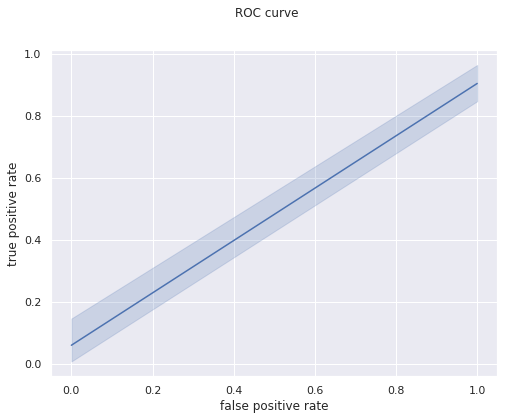

In [15]:
fig = plt.figure(figsize=(8,6))
fig.suptitle("ROC curve")
ax = sns.lineplot(FPR, TPR )
ax.set(xlabel='false positive rate', ylabel='true positive rate')

A présent, nous allons utiliser la librairie Keras pour essayer de résoudre ce problème de régression logistique : en effet, quand on souhaite enfoncer un clou, quoi de mieux qu'un marteau-piqueur ?

In [16]:
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [17]:
#On utilise une fonction de sklearn pour créer les ensembles d'entraînement et de test.
train_df_keras, test_df_keras = train_test_split(cleaned_df_keras, test_size=0.2)
train_df_keras, val_df_keras = train_test_split(train_df_keras, test_size=0.2)
#On extrait les labels et les données
train_labels_keras = np.array(train_df_keras.pop('pit'))
bool_train_labels_keras = train_labels_keras != 0
val_labels_keras = np.array(val_df_keras.pop('pit'))
test_labels_keras = np.array(test_df_keras.pop('pit'))

train_features_keras = np.array(train_df_keras)
val_features_keras = np.array(val_df_keras)
test_features_keras = np.array(test_df_keras)

In [18]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
            16, activation='relu',
            input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
            bias_initializer=output_bias),
        ])

    model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics)

    return model

In [19]:
EPOCHS = 100
BATCH_SIZE = 512

In [20]:
model_keras = make_model()
history = model_keras.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=90,
    validation_data=(val_features_keras, val_labels_keras), 
    verbose=1)

Train on 12488 samples, validate on 22934 samples
Epoch 1/90
12488/12488 [==============================] - 12s 971us/sample - loss: 0.4947 - tp: 1993.0000 - fp: 0.0000e+00 - tn: 8811.0000 - fn: 1684.0000 - accuracy: 0.8652 - precision: 1.0000 - recall: 0.5420 - auc: 0.7536 - val_loss: 0.2698 - val_tp: 698.0000 - val_fp: 0.0000e+00 - val_tn: 22045.0000 - val_fn: 191.0000 - val_accuracy: 0.9917 - val_precision: 1.0000 - val_recall: 0.7852 - val_auc: 0.9888
Epoch 2/90
12488/12488 [==============================] - 1s 79us/sample - loss: 0.4067 - tp: 2293.0000 - fp: 0.0000e+00 - tn: 8811.0000 - fn: 1384.0000 - accuracy: 0.8892 - precision: 1.0000 - recall: 0.6236 - auc: 0.8315 - val_loss: 0.2590 - val_tp: 756.0000 - val_fp: 0.0000e+00 - val_tn: 22045.0000 - val_fn: 133.0000 - val_accuracy: 0.9942 - val_precision: 1.0000 - val_recall: 0.8504 - val_auc: 0.9888
Epoch 3/90
12488/12488 [==============================] - 1s 74us/sample - loss: 0.3756 - tp: 2536.0000 - fp: 0.0000e+00 - tn: 8811.

12488/12488 [==============================] - 2s 123us/sample - loss: 0.1714 - tp: 3316.0000 - fp: 0.0000e+00 - tn: 8811.0000 - fn: 361.0000 - accuracy: 0.9711 - precision: 1.0000 - recall: 0.9018 - auc: 0.9750 - val_loss: 0.1585 - val_tp: 849.0000 - val_fp: 0.0000e+00 - val_tn: 22045.0000 - val_fn: 40.0000 - val_accuracy: 0.9983 - val_precision: 1.0000 - val_recall: 0.9550 - val_auc: 0.9888
Epoch 22/90
12488/12488 [==============================] - 1s 109us/sample - loss: 0.1668 - tp: 3327.0000 - fp: 0.0000e+00 - tn: 8811.0000 - fn: 350.0000 - accuracy: 0.9720 - precision: 1.0000 - recall: 0.9048 - auc: 0.9780 - val_loss: 0.1551 - val_tp: 850.0000 - val_fp: 0.0000e+00 - val_tn: 22045.0000 - val_fn: 39.0000 - val_accuracy: 0.9983 - val_precision: 1.0000 - val_recall: 0.9561 - val_auc: 0.9888
Epoch 23/90
12488/12488 [==============================] - 1s 88us/sample - loss: 0.1600 - tp: 3352.0000 - fp: 0.0000e+00 - tn: 8811.0000 - fn: 325.0000 - accuracy: 0.9740 - precision: 1.0000 - re

12488/12488 [==============================] - 1s 111us/sample - loss: 0.1212 - tp: 3417.0000 - fp: 0.0000e+00 - tn: 8811.0000 - fn: 260.0000 - accuracy: 0.9792 - precision: 1.0000 - recall: 0.9293 - auc: 0.9782 - val_loss: 0.1079 - val_tp: 856.0000 - val_fp: 0.0000e+00 - val_tn: 22045.0000 - val_fn: 33.0000 - val_accuracy: 0.9986 - val_precision: 1.0000 - val_recall: 0.9629 - val_auc: 0.9888
Epoch 42/90
12488/12488 [==============================] - 1s 113us/sample - loss: 0.1160 - tp: 3443.0000 - fp: 0.0000e+00 - tn: 8811.0000 - fn: 234.0000 - accuracy: 0.9813 - precision: 1.0000 - recall: 0.9364 - auc: 0.9816 - val_loss: 0.1060 - val_tp: 856.0000 - val_fp: 0.0000e+00 - val_tn: 22045.0000 - val_fn: 33.0000 - val_accuracy: 0.9986 - val_precision: 1.0000 - val_recall: 0.9629 - val_auc: 0.9888
Epoch 43/90
12488/12488 [==============================] - 2s 129us/sample - loss: 0.1162 - tp: 3438.0000 - fp: 0.0000e+00 - tn: 8811.0000 - fn: 239.0000 - accuracy: 0.9809 - precision: 1.0000 - r

12488/12488 [==============================] - 1s 74us/sample - loss: 0.0971 - tp: 3463.0000 - fp: 0.0000e+00 - tn: 8811.0000 - fn: 214.0000 - accuracy: 0.9829 - precision: 1.0000 - recall: 0.9418 - auc: 0.9788 - val_loss: 0.0786 - val_tp: 861.0000 - val_fp: 0.0000e+00 - val_tn: 22045.0000 - val_fn: 28.0000 - val_accuracy: 0.9988 - val_precision: 1.0000 - val_recall: 0.9685 - val_auc: 0.9888
Epoch 62/90
12488/12488 [==============================] - 1s 74us/sample - loss: 0.0945 - tp: 3478.0000 - fp: 0.0000e+00 - tn: 8811.0000 - fn: 199.0000 - accuracy: 0.9841 - precision: 1.0000 - recall: 0.9459 - auc: 0.9820 - val_loss: 0.0775 - val_tp: 861.0000 - val_fp: 0.0000e+00 - val_tn: 22045.0000 - val_fn: 28.0000 - val_accuracy: 0.9988 - val_precision: 1.0000 - val_recall: 0.9685 - val_auc: 0.9888
Epoch 63/90
12488/12488 [==============================] - 1s 73us/sample - loss: 0.0958 - tp: 3460.0000 - fp: 0.0000e+00 - tn: 8811.0000 - fn: 217.0000 - accuracy: 0.9826 - precision: 1.0000 - reca

12488/12488 [==============================] - 1s 76us/sample - loss: 0.0846 - tp: 3477.0000 - fp: 0.0000e+00 - tn: 8811.0000 - fn: 200.0000 - accuracy: 0.9840 - precision: 1.0000 - recall: 0.9456 - auc: 0.9804 - val_loss: 0.0602 - val_tp: 867.0000 - val_fp: 0.0000e+00 - val_tn: 22045.0000 - val_fn: 22.0000 - val_accuracy: 0.9990 - val_precision: 1.0000 - val_recall: 0.9753 - val_auc: 0.9888
Epoch 82/90
12488/12488 [==============================] - 1s 75us/sample - loss: 0.0814 - tp: 3487.0000 - fp: 0.0000e+00 - tn: 8811.0000 - fn: 190.0000 - accuracy: 0.9848 - precision: 1.0000 - recall: 0.9483 - auc: 0.9818 - val_loss: 0.0595 - val_tp: 868.0000 - val_fp: 0.0000e+00 - val_tn: 22045.0000 - val_fn: 21.0000 - val_accuracy: 0.9991 - val_precision: 1.0000 - val_recall: 0.9764 - val_auc: 0.9888
Epoch 83/90
12488/12488 [==============================] - 1s 72us/sample - loss: 0.0832 - tp: 3481.0000 - fp: 0.0000e+00 - tn: 8811.0000 - fn: 196.0000 - accuracy: 0.9843 - precision: 1.0000 - reca

In [21]:
def plot_loss(history,):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], label='Train')
    plt.semilogy(history.epoch,  history.history['val_loss'], label='Val',
              linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

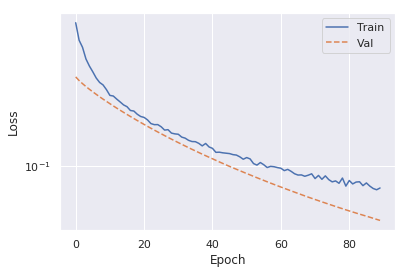

In [22]:
plot_loss(history)

In [23]:
train_predictions_keras = model_keras.predict(train_features_keras, batch_size=BATCH_SIZE)
test_predictions_keras = model_keras.predict(test_features_keras, batch_size=BATCH_SIZE)

In [24]:
test_predictions_keras = np.where(test_predictions_keras > 0.5, 1, 0)

Text(0.5,21.5,'Label predit')

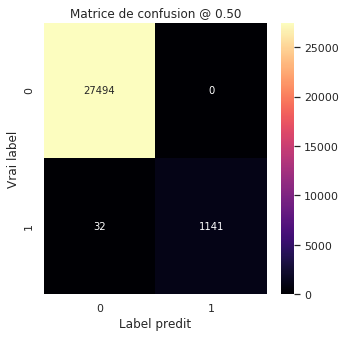

In [25]:
p = 0.5
cm_keras = CM(test_labels_keras,test_predictions_keras)
plt.figure(figsize=(5,5))
sns.heatmap(cm_keras, annot=True, fmt="d", cmap='magma')
plt.title('Matrice de confusion @ {:.2f}'.format(p))
plt.ylabel('Vrai label')
plt.xlabel('Label predit')

In [75]:
TP = cm_keras[1][1] #Vrais positifs
TN = cm_keras[0][0] #Vrais négatifs
FP = cm_keras[0][1] #Faux positifs
FN = cm_keras[1][0] #Faux négatifs
precision = 1.0*TP/(TP+FP)
recall = 1.0*TP/(TP+FN)
accuracy = (1.0*TP+TN)/(TP+TN+FP+FN)
f1 = 2.0*(1.0*precision*recall)/(1.0*precision + recall)
tfp = 1.0*FP/(1.0*FP+TN)
print("Précision : {}".format(precision))
print("Recall : {}".format(recall))
print("Accuracy : {}".format(accuracy))
print("Score F1 : {}".format(f1))
print("TFP : {}".format(tfp))

Précision : 1.0
Recall : 0.961811722913
Accuracy : 0.998500017442
Score F1 : 0.980534178361
TFP : 0.0


En conclusion, nous pouvons dire que, étant donné la répartition des classes, Keras obtient des performances supérieures à une régression logistique classique. On remarque par exemple un score F1 et un rappel impressionnants, de valeur respectivement 0.98 et 0.97.

Essayons, pour terminer cette analyse, de déterminer les pit-stops d'une seule course : nous choisirons par exemple le Grand Prix d'Abu Dhabi 2017 (raceId = 988).

In [67]:
abudhabi = my_dataset[my_dataset['raceId'] == 988]

In [68]:
abudhabi_results = abudhabi['pit'].to_numpy().flatten()
abudhabi_labels = abudhabi['lapDelta'].to_numpy()

In [69]:
abudhabi_preds = model_keras.predict(abudhabi_labels, batch_size=BATCH_SIZE)

In [70]:
abudhabi_preds = np.where(abudhabi_preds > 0.5, 1.0, 0.0).flatten()

In [71]:
def CM(real,predicted):
    matrix = np.zeros((2,2),dtype='int32')
    p = np.array(predicted).flatten()
    r = np.array(real).flatten()
    matrix[1,1] = len(r[(p==r) & (p==1)])        #true positive
    matrix[0,0] = len(r[(p==r) & (p==0)])       #true negative
    matrix[1,0] = len(r[(p!=r) & (r==1)])       # false negative
    matrix[0,1] = len(r[(p!=r) & (r==0)]) # false positive

    return matrix

Text(0.5,21.5,'Label predit')

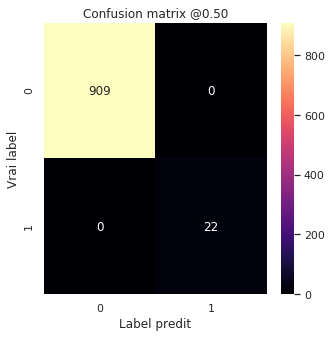

In [72]:
cm_abudhabi = CM(abudhabi_results,abudhabi_preds)
plt.figure(figsize=(5,5))
sns.heatmap(cm_abudhabi, annot=True, fmt="d", cmap='magma')
plt.title('Confusion matrix @{:.2f}'.format(p))
plt.ylabel('Vrai label')
plt.xlabel('Label predit')

On voit que l'algorithme a correctement prédit tous les pit-stops, sans exception.